# MOD600 - Project 2 - Numerical Simulation of Shallow Water Equations

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import sys
import time

#### Define the functions

In [2]:
def A_hat(u_l,u_r,g=9.81):
    h_l = u_l[0]
    h_r = u_r[0]
    v_l = u_l[1]/h_l   
    v_r = u_r[1]/h_r
    h_hat = 0.5*(h_l+h_r)
    v_hat = (np.sqrt(h_l)*v_l+np.sqrt(h_r)*v_r)/(np.sqrt(h_l)+np.sqrt(h_r))
    A_hat_ = [[0,1],[g*h_hat-np.square(v_hat),2*v_hat]]
    return A_hat_

def A_hat_pos(u_l,u_r):
    A_hat_ = A_hat(u_l,u_r)
    lbd, R = np.linalg.eig(A_hat_)
    lbd = np.diag(lbd)
    lbd_p = np.max((lbd,np.zeros_like(lbd)),axis=0)
    R_inv = np.linalg.inv(R)
    A_hat_p = R@lbd_p@R_inv
    return A_hat_p
    
def A_hat_neg(u_l,u_r):
    A_hat_ = A_hat(u_l,u_r)
    lbd, R = np.linalg.eig(A_hat_)
    lbd = np.diag(lbd)
    lbd_n = np.min((lbd,np.zeros_like(lbd)),axis=0)
    R_inv = np.linalg.inv(R)
    A_hat_n = R@lbd_n@R_inv
    return A_hat_n


In [3]:
def u_num(x_l=-25,x_r=25,M_cells = 150, N_time = 2000, T = 100,h_min=0.01,h_max=10):
    
    #discretisation of x (including ghost cells for boundary conditions)
    dx = (x_r-x_l)/M_cells
    print('dx =',np.round(dx,2),'m')
    x_cells = np.linspace(x_l-dx,x_r+dx,M_cells+2)

    #initial condition
    h0 = np.where(x_cells<0,2,1)
    v0 = np.zeros_like(x_cells)

    #definition of u vector:
    #1st value: height --> Conservation of Mass
    #2nd value: height*velocity --> Conservation of Momentum
    u0 = np.array([h0,h0*v0])
    
    #discretisation of time
    T_array = np.linspace(0,T,N_time)
    dt = T/N_time
    print('dt =',np.round(dt,2),'s')

    #initialize u matrix
    u = np.zeros((N_time,M_cells+2,2))

    #apply initial condition
    u[0] = np.transpose(u0)
    
    #numerical scheme
    for n in range(len(T_array)-1):
        #display and update simulation status
        sys.stdout.write('\r')
        sys.stdout.write(str(n+1)+'/'+str(N_time-1)+' --> '+str(np.round(100*(n+1)/(N_time-1),2))+'%                                                                          ')
        sys.stdout.flush()
        
        #reflective boundary conditions
        #1st value (height --> Conservation of Mass)
        u[n,0,0] = u[n,1,0]
        u[n,-1,0] = u[n,-2,0]
        #2nd value (height*velocity --> Conservation of Momentum)
        u[n,0,1] = -u[n,1,1]
        u[n,-1,1] = -u[n,-2,1]
        
        #physicality limitations: h_min <= height <= h_max
        heights = np.min((np.max((np.transpose(u[n])[0],np.ones(M_cells+2)*h_min),axis=0),np.ones(M_cells+2)*h_max),axis=0)
        velocities = np.transpose(u[n])[1]/np.transpose(u[n])[0]
        u[n] = np.transpose(np.array([heights,heights*velocities]))

        #roe scheme
        for j in range(1,len(x_cells)-1):  
            u[n+1,j] = u[n,j]-(dt/dx)*(A_hat_pos(u[n,j-1],u[n,j])@(u[n,j]-u[n,j-1])+A_hat_neg(u[n,j],u[n,j+1])@(u[n,j+1]-u[n,j]))

    return u,x_cells,T_array

### Run the simulation

In [4]:
u,x_cells,T_array = u_num()

dx = 0.33 m
dt = 0.05 s
1999/1999 --> 100.0%                                                                          

### Create the animation

creating animation...
2000/2000 --> 100.0%                                                                          
writing Simulation_20220421-174449.gif file...
done


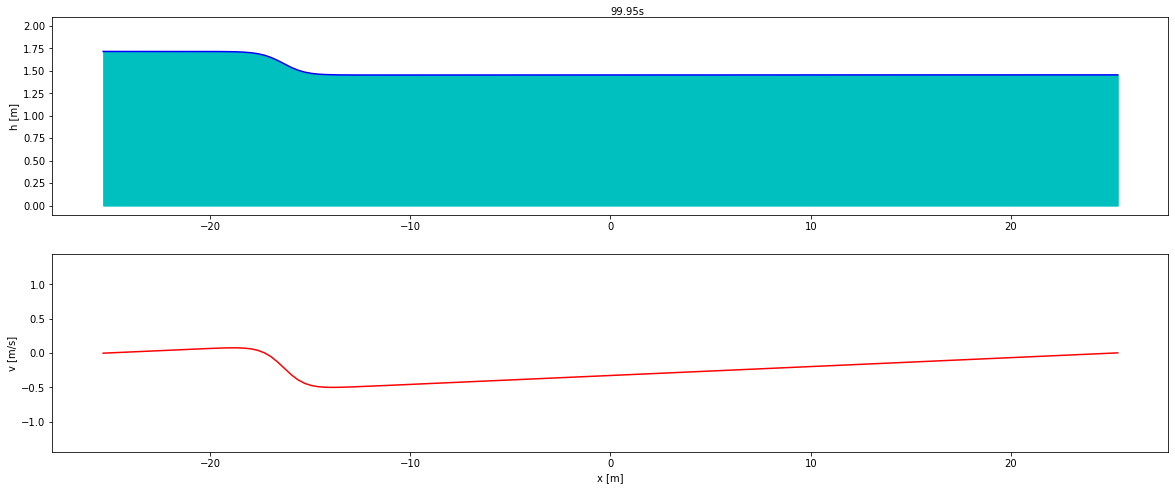

In [5]:
#initialise camera
fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_figheight(8)
fig.set_figwidth(20)
camera = Camera(fig)

end_time = T_array[-1]
times = T_array
t_report = 2
actual_timesteps = len(T_array)
timestr = time.strftime("%Y%m%d-%H%M%S")

#rounding digits for status update
n_digits = np.floor(np.abs(np.log10(end_time)))
round_digits = 2+int(n_digits)

print('creating animation...')
for t,Time in enumerate(times):
    #display and update animation status
    sys.stdout.write('\r')
    sys.stdout.write(str(t+1)+'/'+str(len(times))+' --> '+str(np.round(100*(t+1)/(len(times)),2))+'%                                                                          ')
    sys.stdout.flush()
    if t % t_report == 0:        
        #create plot
        ax1.plot(x_cells,np.transpose(u[t])[0],color='b')
        ax1.fill_between(x_cells,np.transpose(u[t])[0],color='c')
        ax2.plot(x_cells,np.transpose(u[t])[1]/np.transpose(u[t])[0],color='r')
        ax1.set_ylabel('h [m]')
        ax2.set_xlabel('x [m]')
        ax2.set_ylabel('v [m/s]')
        ax1.text(0.5, 1.01, str(np.round(Time,2))+'s', transform=ax1.transAxes)
        camera.snap()

#save animation
print('\nwriting Simulation_'+str(timestr)+'.gif file...')
anim = camera.animate(blit=True)
anim.save('Simulation_'+str(timestr)+'.gif',writer='pillow')
print('done')